Max absolute difference between analytical solution and TensorFlow DNN =  0.7452600488440986


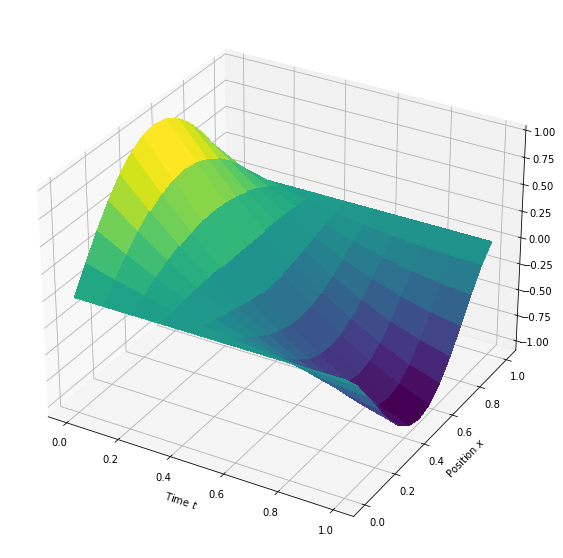

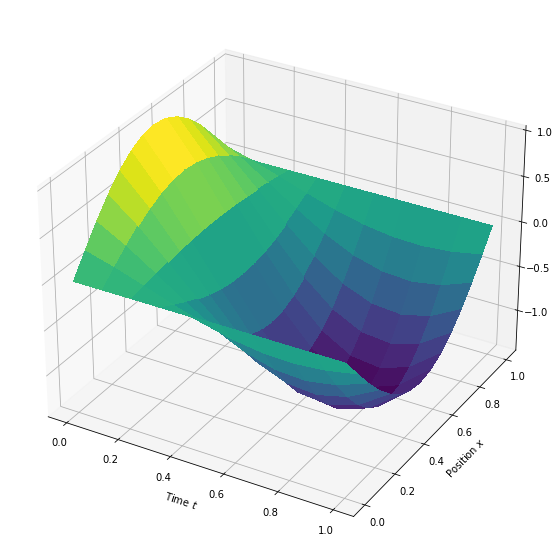

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
# Tensorflow/keras
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
tf.keras.backend.set_floatx('float64')

def u(x):
    return tf.sin(np.pi*x)

def v(x):
    return -np.pi*tf.sin(np.pi*x)

def loss(model, x, t):
    with tf.GradientTape() as tapex, tf.GradientTape() as tapet:
        tapex.watch([x])
        tapet.watch([t])
        with tf.GradientTape() as tapexfirst, tf.GradientTape() as tapetfirst:
            tapexfirst.watch([x])
            tapetfirst.watch([t])
            g_trial = (1 - t**2) * u(x) + t * v(x) + x * (1 - x) * t**2 * model(points)

        dg_dx = tapexfirst.gradient(g_trial, x)
        dg_dt = tapetfirst.gradient(g_trial, t)

    dg_d2x = tapex.gradient(dg_dx, x)
    dg_d2t = tapet.gradient(dg_dt, t)

    return tf.losses.mean_squared_error(zeros, dg_d2t - dg_d2x)

def train(model, optimizer, x, t):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x, t)
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Nx = 15
Nt = 10

x_np = np.linspace(0, 1, Nx)
t_np = np.linspace(0, 1, Nt)

X, T = np.meshgrid(x_np, t_np)

x = X.ravel()
t = T.ravel()

## The construction phase

zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)), shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x), shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t), shape=(-1,1))

points = tf.concat([x,t], 1)

num_iter = 100000

X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

model = Sequential()
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1))
model.build(points.shape)
eta = 0.001
sgd = optimizers.SGD(lr=eta)

for i in range(100):
    train(model, sgd, x, t)
    
g_dnn = (1 - t**2) * u(x) + t * v(x) + x * (1 - x) * t**2 * model(points)
g_dnn = np.array(g_dnn)

G_dnn = g_dnn.reshape((Nt,Nx))

g_analytic = tf.sin(np.pi*x) * tf.cos(np.pi*t) - tf.sin(np.pi*x) * tf.sin(np.pi*t)
G_analytic = np.array(g_analytic).reshape((Nt,Nx))

# Plot the results

X, T = np.meshgrid(x_np, t_np)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
s = ax.plot_surface(T, X, G_dnn, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
s = ax.plot_surface(T, X, G_analytic, linewidth=0, antialiased=False, cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')

## Compare with the analutical solution
diff = np.abs(g_analytic - g_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = ',np.max(diff))